## Packages

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from tqdm import tqdm


# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

# Cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

# CLassification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Performance
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Warnings
from sklearn.exceptions import ConvergenceWarning
import warnings



## Helpers

In [44]:
def date(date_str: str) -> pd.Timestamp:
    """
    Convertit une chaîne contenant une année et un mois (dans n'importe quel ordre ou séparateur)
    en un Timestamp pandas correspondant au 15 du mois à 00:00:00.
    
    Exemples acceptés : '01 2017', '2017 01', '2017-01', '2017/01', 'Jan 2017', '2017 January'
    """
    date_str = date_str.strip().lower()
    
    # Essayons d'abord via pandas to_datetime (qui gère bien les formats flexibles)
    try:
        parsed_date = pd.to_datetime(date_str, errors='raise', dayfirst=False)
        return pd.Timestamp(year=parsed_date.year, month=parsed_date.month, day=15)
    except Exception:
        pass
    
    # Sinon on essaie d'extraire les entiers via regex
    numbers = re.findall(r'\d+', date_str)
    if len(numbers) != 2:
        raise ValueError("Impossible d'extraire mois et année de la chaîne.")

    nums = sorted([int(n) for n in numbers])  # année sera le plus grand nombre
    year = max(nums)
    month = min(nums)
    if not (1 <= month <= 12):
        raise ValueError(f"Mois invalide : {month}")

    return pd.Timestamp(year=year, month=month, day=15)

## Dataset

In [45]:
#Paramètres des données

lags = 18

In [46]:
data = pd.read_csv('data.csv', index_col=0)
data.index = pd.to_datetime(data.index)
#data.index

In [47]:
spi = pd.read_excel('data_spi.xlsx', index_col=0)
spi.index = pd.to_datetime(spi.index)
# Regroupe par année et mois, puis calcule la moyenne
spi = spi.resample('M').mean()

# Remplace l'index (qui est le dernier jour du mois) par le 15 du même mois
spi.index = spi.index.to_period('M').to_timestamp() + pd.Timedelta(days=14)
#spi

C:\Users\vadim\AppData\Local\Temp\ipykernel_15784\4254966247.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [48]:
tp = pd.read_excel('BDD TP Nowcasted.xlsx', index_col=0)
tp.index = pd.to_datetime(tp.index) + pd.DateOffset(day = 15)  # Décalage d'un mois
tp = tp.iloc[:,-1]
#tp.index

C:\Users\vadim\AppData\Local\Temp\ipykernel_15784\3061312165.py:2: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex.



In [49]:
BDD = pd.concat([data, spi, tp], axis=1)
BDD.sort_index(inplace=True)

BDD.dropna(inplace=True)
BDD.rename(columns={BDD.columns[-1]: "target"}, inplace=True)



In [50]:
if lags > 0:
    diff_features = {}

    for col in BDD.columns[:-1]:  # Exclut la colonne cible
        for lag in range(1, lags+1):
            diff_features[f"{col}_diff_{lag}"] = BDD[col].diff(lag)

    # Création d'un DataFrame unique, puis concaténation une fois
    df_diff = pd.DataFrame(diff_features, index=BDD.index)
    BDD = pd.concat([BDD, df_diff], axis=1)
    target_col = "target"
    BDD = BDD[[col for col in BDD.columns if col != target_col] + [target_col]]


    BDD.bfill(inplace=True)

In [51]:
BDD

,S&P 500 COMPOSITE - PRICE INDEX,cmdty BLS Commodity Price Ind 'DEAD' - PRICE INDEX,Gold Bullion LBM $/t oz DELAY,Crude Oil-WTI Spot Cushing U$/BBL,US INITIAL CLAIMS FOR UNEMPLOYMENT INSURANCE (BCI 5) VOLA,US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME SALES-CURRENTLY,US CONSUMER CONFIDENCE INDEX SADJ,US CONSUMER CONFIDENCE INDEX - EXPECTATIONS SADJ,US CONSUMER CONFIDENCE INDEX - PRESENT SITUATION SADJ,US CONSUMER CONFIDENCE CURRENTLY - JOBS PLENTIFUL SADJ,...,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_10,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_11,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_12,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_13,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_14,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_15,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_16,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_17,US BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND_diff_18,target
1988-01-15,257.07,258.89,456.25,16.95,340.8,56.0,109.9,102.2,121.5,29.5,...,4.494205,4.313750,5.129341,5.260750,4.801011,6.745350,9.456924,14.087886,16.674845,1.0
1988-02-15,267.82,257.00,425.00,16.08,318.8,55.0,114.9,105.5,129.1,31.4,...,4.494205,4.313750,5.129341,5.260750,4.801011,6.745350,9.456924,14.087886,16.674845,1.0
1988-03-15,258.89,261.20,456.25,17.08,306.0,55.0,112.7,104.9,124.5,28.9,...,4.494205,4.313750,5.129341,5.260750,4.801011,6.745350,9.456924,14.087886,16.674845,1.0
1988-04-15,261.33,263.50,449.00,18.00,313.0,57.0,115.7,112.8,120.2,27.8,...,4.494205,4.313750,5.129341,5.260750,4.801011,6.745350,9.456924,14.087886,16.674845,1.0
1988-05-15,262.16,272.55,454.75,17.54,313.8,58.0,120.2,114.4,129.0,30.8,...,4.494205,4.313750,5.129341,5.260750,4.801011,6.745350,9.456924,14.087886,16.674845,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,3955.00,398.56,1719.56,90.05,216.8,57.0,103.6,75.8,145.3,47.6,...,-69.891453,-82.241648,-85.920194,-82.083648,-68.665694,-60.708263,-59.038012,-56.367043,-76.893389,1.0
2022-09-15,3585.62,398.56,1674.06,79.94,197.5,54.0,107.8,79.5,150.2,49.2,...,-99.887545,-97.720760,-110.070955,-113.749500,-109.912955,-96.495000,-88.537569,-86.867318,-84.196350,1.0
2022-10-15,3871.98,398.56,1638.03,86.53,202.5,45.0,102.2,77.9,138.7,44.8,...,-128.071778,-121.125452,-118.958667,-131.308861,-134.987407,-131.150861,-117.732907,-109.775476,-108.105225,1.0
2022-11-15,4080.11,398.56,1751.94,80.45,211.5,39.0,101.4,76.7,138.3,45.2,...,-105.974970,-122.466462,-115.520136,-113.353351,-125.703545,-129.382091,-125.545545,-112.127591,-104.170160,1.0


## ML

In [52]:
# Paramètres
start_date = '2000-01-15'  # Exemple de date de départ pour les prédictions
k = 6  # Nombre de mois d'écart (par exemple 12 pour 1 an)

In [53]:
# Pour ignorer les warnings de convergence éventuels
warnings.simplefilter("ignore", ConvergenceWarning)

# Initialisation
BDD_X = BDD.iloc[:, :-1]
BDD_y = BDD.iloc[:, -1]
dates = BDD.index

# DataFrames pour stocker les résultats
y_test_label = pd.DataFrame(np.nan, index=BDD.index, columns=['RF_label', 'GB_label', 'MLP_label', 'EN_label'])
y_test_probs = pd.DataFrame(np.nan, index=BDD.index, columns=['RF_probs', 'GB_probs', 'MLP_probs', 'EN_probs'])
var_imp_RF = pd.DataFrame(np.nan, index=BDD.index, columns=BDD_X.columns)
var_imp_GB = pd.DataFrame(np.nan, index=BDD.index, columns=BDD_X.columns)
var_imp_EN = pd.DataFrame(np.nan, index=BDD.index, columns=BDD_X.columns)

# Boucle sur chaque date
for date in tqdm(BDD.loc[start_date:].index):
    idx_date = BDD.index.get_loc(date)
    if idx_date - k <= 0:
        continue # pas assez de données avant la date de prédiction

    X_train = BDD_X.iloc[:idx_date - k]
    y_train = BDD_y.iloc[:idx_date - k]
    X_test = BDD_X.iloc[[idx_date]]
    y_true = BDD_y.iloc[idx_date]

    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----- Random Forest -----
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_test_label.loc[date, 'RF_label'] = rf.predict(X_test_scaled)[0]
    y_test_probs.loc[date, 'RF_probs'] = rf.predict_proba(X_test_scaled)[0][1]
    var_imp_RF.loc[date] = rf.feature_importances_ * 100

    # ----- Gradient Boosting -----
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    gb.fit(X_train_scaled, y_train)
    y_test_label.loc[date, 'GB_label'] = gb.predict(X_test_scaled)[0]
    y_test_probs.loc[date, 'GB_probs'] = gb.predict_proba(X_test_scaled)[0][1]
    var_imp_GB.loc[date] = gb.feature_importances_ * 100

    # ----- MLP Classifier -----
    mlp = MLPClassifier(hidden_layer_sizes=(126,32,8), max_iter=500, random_state=42)
    mlp.fit(X_train_scaled, y_train)
    y_test_label.loc[date, 'MLP_label'] = mlp.predict(X_test_scaled)[0]
    y_test_probs.loc[date, 'MLP_probs'] = mlp.predict_proba(X_test_scaled)[0][1]
    # Pas d'importances directes pour MLP

    # ----- ElasticNet Logistic Regression -----
    en = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000, random_state=42)
    en.fit(X_train_scaled, y_train)
    y_test_label.loc[date, 'EN_label'] = en.predict(X_test_scaled)[0]
    y_test_probs.loc[date, 'EN_probs'] = en.predict_proba(X_test_scaled)[0][1]
    var_imp_EN.loc[date] = np.abs(en.coef_[0]) * 100  # Coefficients comme importance


  0%|          | 0/276 [00:00<?, ?it/s]

  4%|▍         | 12/276 [03:29<1:16:59, 17.50s/it]


KeyboardInterrupt: 

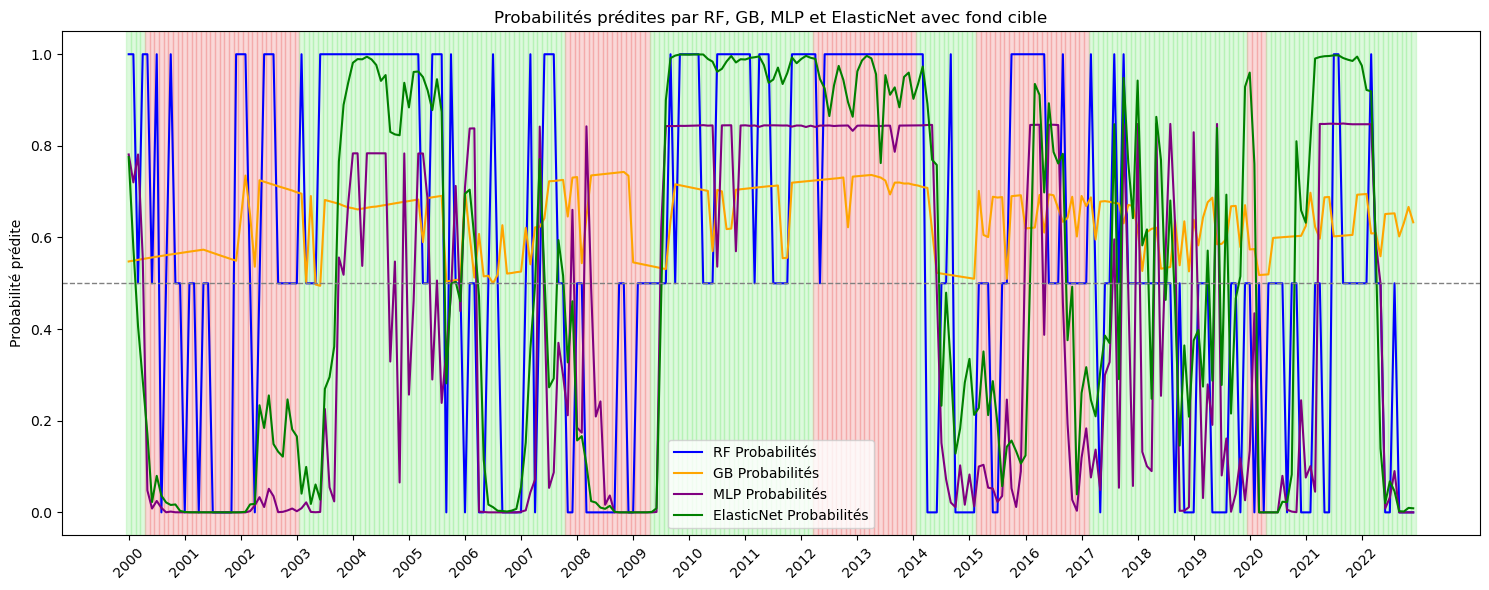

In [ ]:
plot_dates = y_test_probs.dropna().index
targets = BDD.loc[plot_dates, 'target']

# Récupérer les probabilités pour chaque modèle
probs_rf = y_test_probs.loc[plot_dates, 'RF_probs']
probs_gb = y_test_probs.loc[plot_dates, 'GB_probs']
probs_mlp = y_test_probs.loc[plot_dates, 'MLP_probs']
probs_en = y_test_probs.loc[plot_dates, 'EN_probs']

plt.figure(figsize=(15, 6))

# Affichage du fond coloré en fonction de la vraie cible
for i, date in enumerate(plot_dates):
    color = 'lightgreen' if targets.loc[date] == 1 else 'lightcoral'
    plt.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.3)

# Courbes des probabilités prédites
plt.plot(probs_rf.values, label='RF Probabilités', color='blue')
plt.plot(probs_gb.values, label='GB Probabilités', color='orange')
plt.plot(probs_mlp.values, label='MLP Probabilités', color='purple')
plt.plot(probs_en.values, label='ElasticNet Probabilités', color='green')

plt.axhline(0.5, color='grey', linestyle='--', linewidth=1)

# Ticks annuels sur l'axe des x
years = plot_dates.year
_, first_indices = np.unique(years, return_index=True)

xticks_pos = first_indices
xticks_labels = [plot_dates[i].strftime('%Y') for i in first_indices]

plt.xticks(ticks=xticks_pos, labels=xticks_labels, rotation=45)
plt.ylabel('Probabilité prédite')
plt.title('Probabilités prédites par RF, GB, MLP et ElasticNet avec fond cible')
plt.legend()
plt.tight_layout()
plt.savefig(f"Results/probabilites_prediction_k={k}.png", dpi=300)  # ← Ajout ici
plt.show()


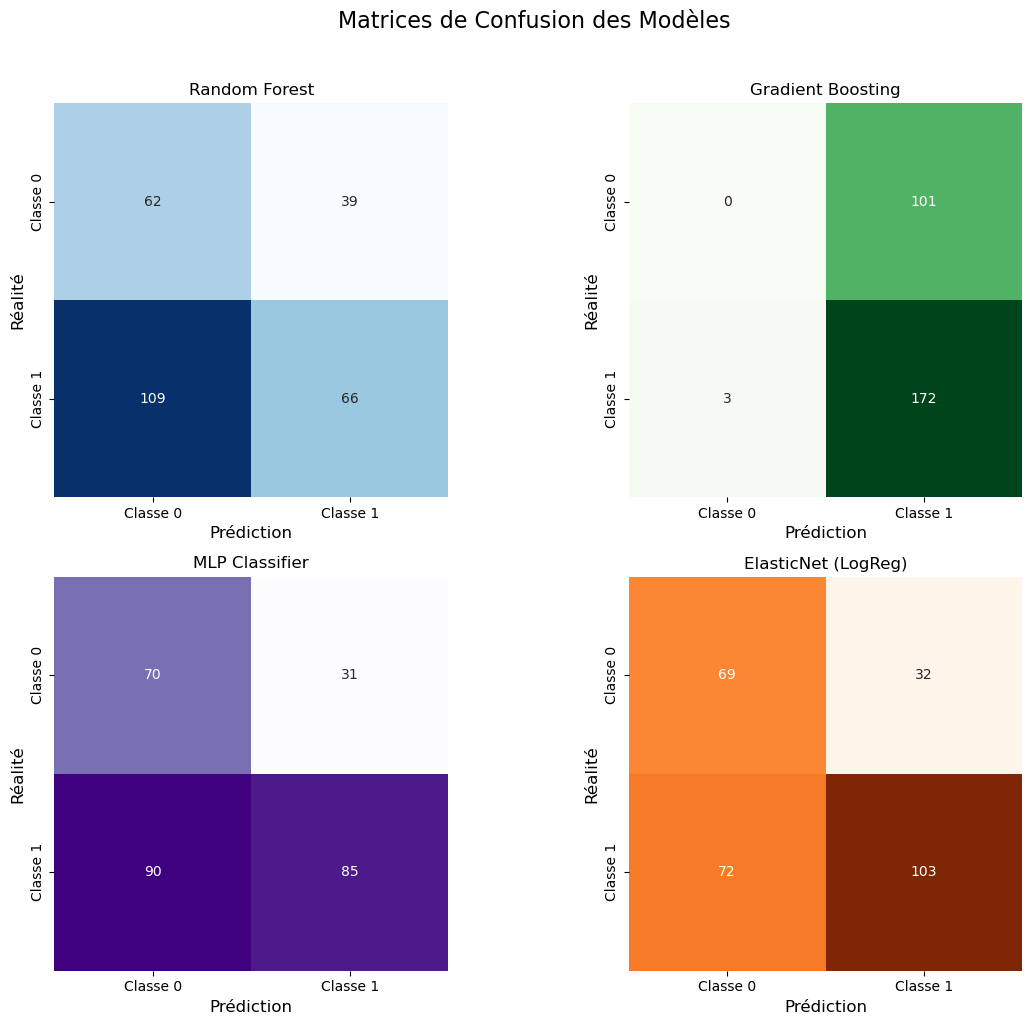

,Accuracy,ROC AUC,Precision,Recall,F1 Score,MSE
Random Forest,0.464,0.499,0.629,0.377,0.471,0.536
Gradient Boosting,0.623,0.363,0.630,0.983,0.768,0.377
MLP,0.562,0.629,0.733,0.486,0.584,0.438
ElasticNet,0.623,0.706,0.763,0.589,0.665,0.377


In [ ]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score, mean_squared_error
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Récupération des vraies cibles et des prédictions finales
valid_index = y_test_label.dropna().index
y_true = BDD.loc[valid_index, 'target']

# Prédictions et probabilités
y_pred_rf = y_test_label.loc[valid_index, 'RF_label']
y_pred_gb = y_test_label.loc[valid_index, 'GB_label']
y_pred_mlp = y_test_label.loc[valid_index, 'MLP_label']
y_pred_en = y_test_label.loc[valid_index, 'EN_label']

y_prob_rf = y_test_probs.loc[valid_index, 'RF_probs']
y_prob_gb = y_test_probs.loc[valid_index, 'GB_probs']
y_prob_mlp = y_test_probs.loc[valid_index, 'MLP_probs']
y_prob_en = y_test_probs.loc[valid_index, 'EN_probs']

# Fonction pour calculer les métriques
def get_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_prob),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred)
    }

# Calcul des scores pour chaque modèle
metrics_rf = get_metrics(y_true, y_pred_rf, y_prob_rf)
metrics_gb = get_metrics(y_true, y_pred_gb, y_prob_gb)
metrics_mlp = get_metrics(y_true, y_pred_mlp, y_prob_mlp)
metrics_en = get_metrics(y_true, y_pred_en, y_prob_en)

# Matrices de confusion
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

labels = ['Classe 0', 'Classe 1']

sns.heatmap(confusion_matrix(y_true, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 0], square=True, cbar=False)
axes[0, 0].set_title('Random Forest')

sns.heatmap(confusion_matrix(y_true, y_pred_gb), annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 1], square=True, cbar=False)
axes[0, 1].set_title('Gradient Boosting')

sns.heatmap(confusion_matrix(y_true, y_pred_mlp), annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 0], square=True, cbar=False)
axes[1, 0].set_title('MLP Classifier')

sns.heatmap(confusion_matrix(y_true, y_pred_en), annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 1], square=True, cbar=False)
axes[1, 1].set_title('ElasticNet (LogReg)')

for ax in axes.flatten():
    ax.set_xlabel('Prédiction', fontsize=12)
    ax.set_ylabel('Réalité', fontsize=12)

plt.suptitle('Matrices de Confusion des Modèles', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(f"Results/confusion_matrices_k={k}.png", dpi=300)  # ← Ajout ici
plt.show()

# Tableau récapitulatif des scores
score_df = pd.DataFrame(
    [metrics_rf, metrics_gb, metrics_mlp, metrics_en],
    index=['Random Forest', 'Gradient Boosting', 'MLP', 'ElasticNet']
)
display(score_df.style.format("{:.3f}").set_caption("Scores des modèles"))


C:\Users\vadim\AppData\Local\Temp\ipykernel_15784\1862488330.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\vadim\AppData\Local\Temp\ipykernel_15784\1862488330.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\vadim\AppData\Local\Temp\ipykernel_15784\1862488330.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




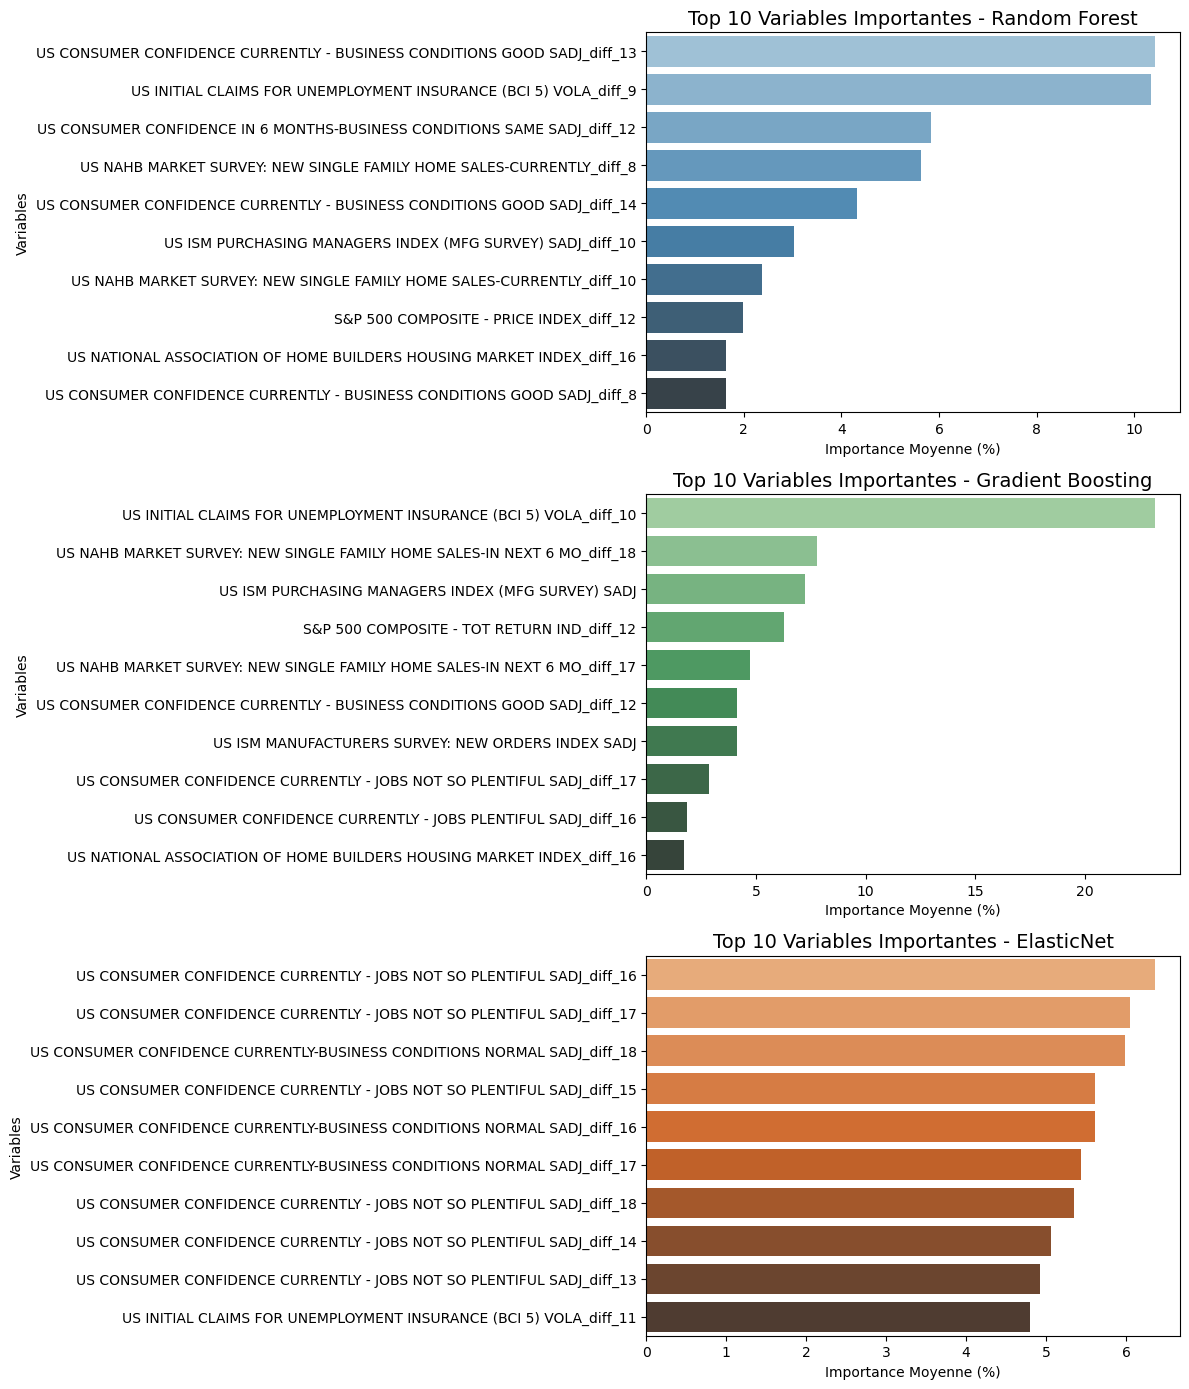

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Moyennes des importances
mean_imp_rf = var_imp_RF.mean().sort_values(ascending=False).head(10)
mean_imp_gb = var_imp_GB.mean().sort_values(ascending=False).head(10)
mean_imp_en = var_imp_EN.mean().sort_values(ascending=False).head(10)

# Création du graphe 3x1 (une ligne par modèle)
fig, axes = plt.subplots(3, 1, figsize=(12, 14))  # Largeur réduite, hauteur augmentée

# Plot Random Forest
sns.barplot(
    x=mean_imp_rf.values,
    y=mean_imp_rf.index,
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title('Top 10 Variables Importantes - Random Forest', fontsize=14)
axes[0].set_xlabel('Importance Moyenne (%)')
axes[0].set_ylabel('Variables')

# Plot Gradient Boosting
sns.barplot(
    x=mean_imp_gb.values,
    y=mean_imp_gb.index,
    palette='Greens_d',
    ax=axes[1]
)
axes[1].set_title('Top 10 Variables Importantes - Gradient Boosting', fontsize=14)
axes[1].set_xlabel('Importance Moyenne (%)')
axes[1].set_ylabel('Variables')

# Plot ElasticNet
sns.barplot(
    x=mean_imp_en.values,
    y=mean_imp_en.index,
    palette='Oranges_d',
    ax=axes[2]
)
axes[2].set_title('Top 10 Variables Importantes - ElasticNet', fontsize=14)
axes[2].set_xlabel('Importance Moyenne (%)')
axes[2].set_ylabel('Variables')

plt.tight_layout()
plt.savefig(f"Results/var_imp_k={k}.png", dpi=300)  # ← Ajout ici
plt.show()
